In [39]:
import numpy
import os, glob
import ipywidgets
import pandas

from matplotlib import pyplot
from IPython.display import display, clear_output

PATH = "../data"

def get_files():
    """
    Returns a `list` of possible folders
    
    :returns : A `list` of folder names
    """
    files = []
    for obj in os.listdir(PATH):
        if ("debug" in obj) or ("backup" in obj):
            continue
        if os.path.isdir(os.path.join(PATH, obj)):
            files.append(obj)    
    return files

def sliding_window(x, kernel_size):
    """
    Computes a sliding window average over the specified data
    
    :param x: A `numpy.ndarray` of the data
    :param kernel_size: An `int` of the size of the sliding window
    
    :returns : A `numpy.ndarray` of the averaged data
    """
    if kernel_size < 2:
        return x
    window = windows.boxcar(kernel_size)
    window = window / window.sum()
    _x = numpy.pad(x, (kernel_size, kernel_size), mode="edge")
    return numpy.convolve(_x, window, mode="same")[kernel_size : -kernel_size]

def plot_score(df, x, y, shade_keys=None, smooth=1):
    """
    Plots the scores from a `pandas.DataFrame` using the provided 
    key
    
    :param df: A `pandas.DataFrame`
    :param key: A `str` of the desired key
    :param shade_keys: A `list` of keys to use as shade
    :param xlabel:
    
    :returns : A `matplotlib.Figure` of the created plot
               A `matplotlib.Axes` of the create plot
    """
    fig, ax = pyplot.subplots(figsize=(5,5))
    lines = ax.plot(df[x], sliding_window(df[y], smooth))
    if isinstance(shade_keys, (tuple, list)):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys[0]], smooth), 
            sliding_window(df[y] + df[shade_keys[1]], smooth), 
            alpha=0.3
        )
    elif isinstance(shade_keys, str):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys], smooth), 
            sliding_window(df[y] + df[shade_keys], smooth), 
            alpha=0.3
        )
    ax.set(
        xlabel=x, ylabel=y
    )
    return fig, ax

def update_figure(model_name):
    """
    Updates the figure
    """
    smoothing_factor = 0
    if not os.path.isfile(os.path.join(PATH, model_name, "scores.txt")):
        print(f"`{model_name}` does not contain any scores...")
        return 
    # If contains backup we read all data points
    files = glob.glob(os.path.join(PATH, model_name + "*"))
    dfs, last_step = [], 0
    for file in files:
        df = pandas.read_csv(os.path.join(file, "scores.txt"), sep="\t")
        df["steps"] += last_step
        last_step = max(df["steps"])
        dfs.append(df)
        if "backup" not in file:
            print(df["steps"].max())
    df = pandas.concat(dfs)
    if df.empty:
        print(f"`{model_name}` does not contain any scores...")
        return 
    fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor) 

Dropdown(index=140, options=('20210716-082307', '20210716-082404', '20210719-105620', '20210719-162126', '2021…

300000


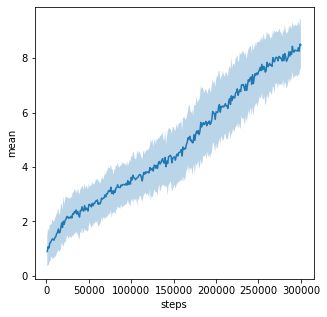

In [40]:
def on_dropdown_change_callback(change):
    """
    Handles the dropdown change
    
    :param change: A `dict` about the change event
    """
    if change["type"] == "change" and change["name"] == "value":
        # Clears the current output
        clear_output()
        # Re-display the widget
        display(dropdown)
        # Update the figure
        update_figure(change["new"])
    
dropdown = ipywidgets.Dropdown(
    options=sorted(get_files())
)
dropdown.observe(on_dropdown_change_callback)
display(dropdown)
# Updates the plot with current value
update_figure(dropdown.value)